In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pickle

BOATS_PATH = ".data/boats_440_5000.pickle"
RACE_PATH = ".data/infos_440.pickle"

with open(BOATS_PATH, 'rb') as f:
    vg_boats = pickle.load(f)
    
with open(RACE_PATH, 'rb') as f:
    vg_infos = pickle.load(f)

In [274]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 70 # 200 e.g. is really fine, but slower

# Plot

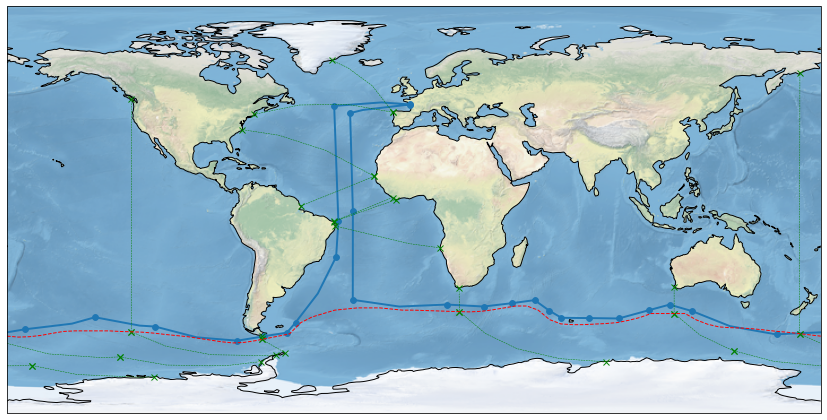

In [8]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

x = [p["lon"] for p in vg_infos["course"]]
y = [p["lat"] for p in vg_infos["course"]]
plt.plot(x, y, 'o-', transform=ccrs.Geodetic(), linewidth=2)

for c in vg_infos["checkpoints"]:
    plt.plot([c["start"]["lon"], c["end"]["lon"]] , [c["start"]["lat"], c["end"]["lat"]], 'xg--', linewidth=0.5, transform=ccrs.Geodetic())

ice_limits = vg_infos["ice_limits"]["south"]
plt.plot([p["lon"] for p in ice_limits] , [p["lat"] for p in ice_limits], 'r--', linewidth=1, transform=ccrs.Geodetic())
    
#lon_pts, lat_pts  = get_next_checkpoint(vg_infos["checkpoints"], 0)
#plt.plot(lon_pts, lat_pts, '--', linewidth=3, transform=ccrs.Geodetic())

# Load worldmap data

In [15]:
from dataset.weather import WeatherGrabber

weather_grabber = WeatherGrabber(".data/grib")

In [16]:
from datetime import datetime

date = datetime(2020, 12, 1)
ds = weather_grabber.get_weather(date)
ds

<xarray.Dataset>
Dimensions:            (latitude: 181, longitude: 360)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  int64 ...
  * latitude           (latitude) float64 90.0 89.0 88.0 ... -88.0 -89.0 -90.0
  * longitude          (longitude) float64 -180.0 -179.0 -178.0 ... 178.0 179.0
    valid_time         datetime64[ns] ...
Data variables:
    u10                (latitude, longitude) float32 0.8441 0.7541 ... -1.516
    v10                (latitude, longitude) float32 -4.986 -5.006 ... -1.116
    u_norm             (latitude, longitude) float32 0.1669 0.149 ... -0.8054
    v_norm             (latitude, longitude) float32 -0.986 -0.9888 ... -0.5927
    wind_speed         (latitude, longitude) float32 5.057 5.062 ... 1.881 1.882
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-02-04T22:31:07 GRIB to CDM+CF via cfgrib-0....

In [418]:
import numpy as np

def bear(latA, lonA, latB, lonB):
    # BEAR Finds the bearing from one lat / lon point to another.
    return np.arctan2(
        np.sin(lonB - lonA) * np.cos(latB),
        np.cos(latA) * np.sin(latB) - np.sin(latA) * np.cos(latB) * np.cos(lonB - lonA)
    )

# https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836
# https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
def haversine_np(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


# https://stackoverflow.com/questions/32771458/distance-from-lat-lng-point-to-minor-arc-segment
#http://www.movable-type.co.uk/scripts/latlong.html
def pointToLineDistance(lon1, lat1, lon2, lat2, lon3, lat3):
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    lat3 = np.radians(lat3)
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    lon3 = np.radians(lon3)
    R = 6371 #6378137 # // Earth's radius in meters
    
    #print(lon3.shape, lat3.shape)

    bear12 = bear(lat1, lon1, lat2, lon2)
    bear13 = bear(lat1, lon1, lat3, lon3)
    dis13 = haversine_np(lat1, lon1, lat3, lon3, to_radians=False)
    
    print(bear13.shape)
    #print(bear12)

    # Is relative bearing obtuse?
    mask = np.fabs(bear13 - bear12) > (math.pi / 2)

    # Find the cross-track distance.
    dxt = np.arcsin(np.sin(dis13 / R) * np.sin(bear13 - bear12)) * R

    # Is p4 beyond the arc?
    dis12 = haversine_np(lat1, lon1, lat2, lon2, to_radians=False)    
    dis14 = np.arccos(np.cos(dis13 / R) / np.cos(dxt / R)) * R
    mask2 = (dis14 > dis12)
    mask2_val = haversine_np(lat2, lon2, lat3, lon3, to_radians=False)
    
    DIST = np.fabs(dxt)
    
    # Result (first try)
    #result = DIST
    #result = result.where(~mask2, other=mask2_val)
    #result = result.where(~mask, other=dis13)
    
    result = dis13.where(mask)
    result2 = mask2_val.where(mask2 & ~(mask))
    result3 = DIST.where(~mask2 & ~mask)

    return result.combine_first(result2).combine_first(result3)

NameError: name 'mask2' is not defined

# Calculate distance to line

In [422]:
pt = vg_infos["checkpoints"][0]
LON1 = pt["start"]["lon"]
LAT1 = pt["start"]["lat"]
LON2 = pt["end"]["lon"]
LAT2 = pt["end"]["lat"]

ds = ds.assign(distance=lambda x: pointToLineDistance(LON1, LAT1, LON2, LAT2, x.longitude, x.latitude))

(360, 181)


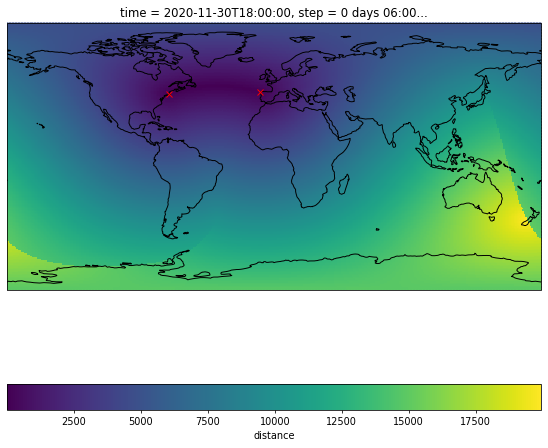

In [423]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds.distance.plot(cbar_kwargs={'orientation': 'horizontal'})
ax.coastlines()
plt.plot(LON1, LAT1, "xr")
plt.plot(LON2, LAT2, "xr")
plt.tight_layout()

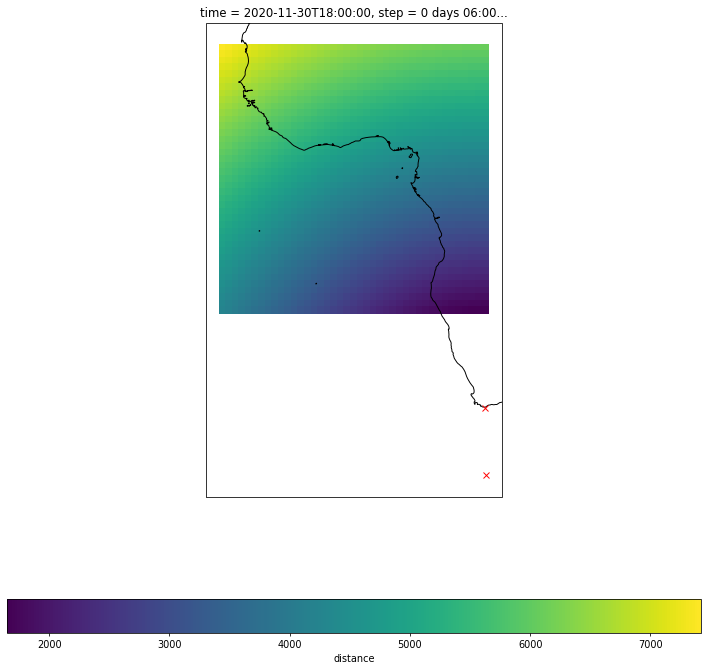

In [313]:
dsi = ds.sel(
        longitude=slice(-20,20), 
        latitude=slice(20, -20)
)

ax = plt.axes(projection=ccrs.PlateCarree())
dsi.distance.plot(cbar_kwargs={'orientation': 'horizontal'})
ax.coastlines()
plt.plot(LON1, LAT1, "xr")
plt.plot(LON2, LAT2, "xr")
plt.tight_layout()

In [352]:
dist = dsi.distance.values
dist *= (255.0/dist.max()) # normalize
#dist

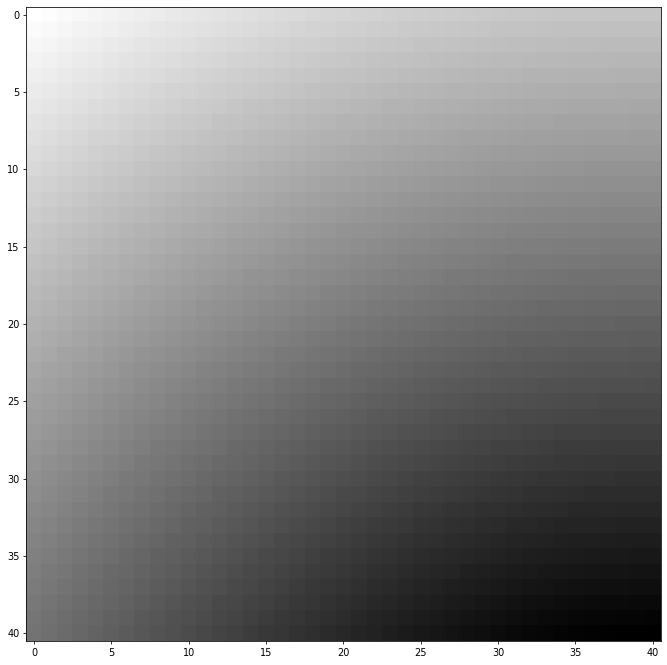

In [353]:
plt.imshow(dist, cmap='gray')